In [1]:
import numpy as np
import cv2
import imutils
from matplotlib import pyplot as plt
import pytesseract
import csv
import datetime

In [2]:
#função para visualização de imagens

def mostrar(img):
  fig = plt.gcf()
  fig.set_size_inches(20, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

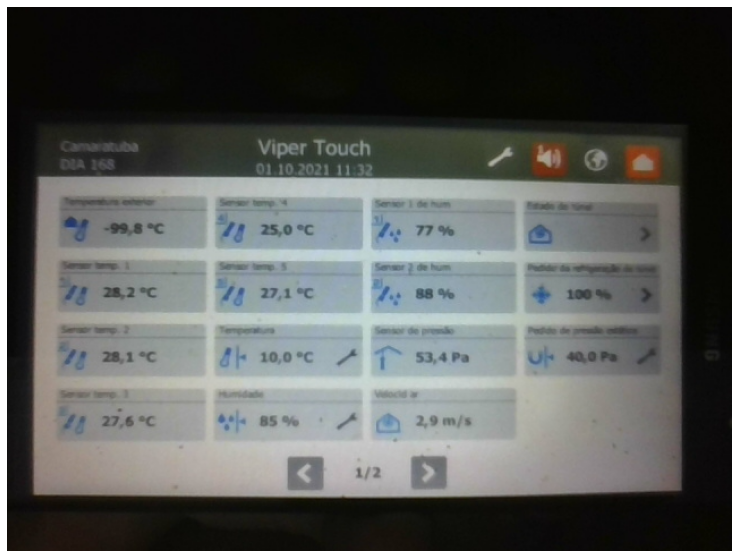

In [3]:
# Processamentos na imagem (enquadramento da tela)

#Abrindo imagem
img = cv2.imread('Foto_camera.png')
original = img.copy()
mostrar(img)

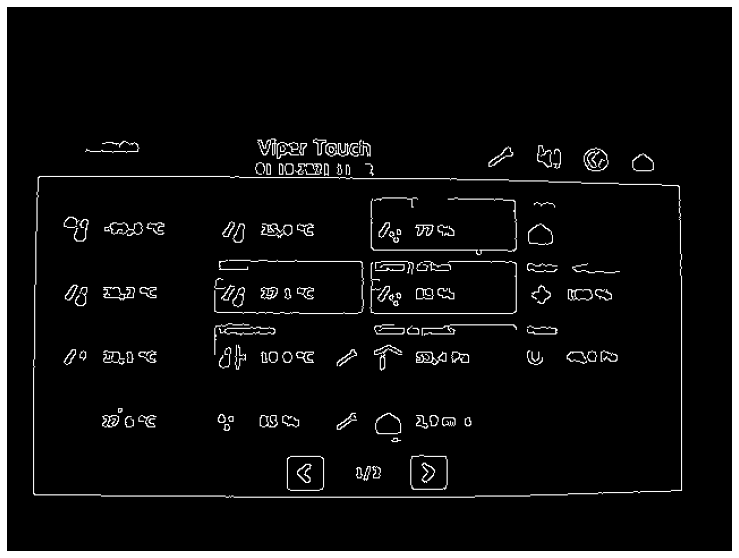

In [4]:
(H, W) = img.shape[:2]

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

blur = cv2.GaussianBlur(gray, (3, 3), 0)

edged = cv2.Canny(blur, 60, 160)

mostrar(edged)

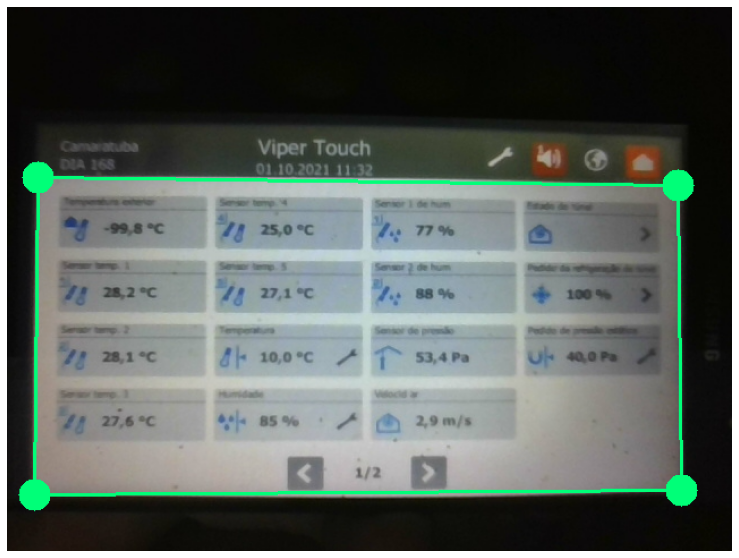

In [5]:
# Detecção de contornos na imagem

def encontrar_contornos(img):
  conts = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  conts = imutils.grab_contours(conts)
  conts = sorted(conts, key = cv2.contourArea, reverse = True)[:6]
  return conts

conts = encontrar_contornos(edged.copy())


# Localizando o maior contorno

for c in conts:
  perimetro = cv2.arcLength(c, True)
  aproximacao = cv2.approxPolyDP(c, 0.02 * perimetro, True)
  if len(aproximacao) == 4:
    maior = aproximacao
    break

cv2.drawContours(img, maior, -1, (120, 255, 0), 28)
cv2.drawContours(img, [maior], -1, (120, 255, 0), 2)
mostrar(img)

In [6]:
#Transformação geométrica

def ordenar_pontos(pontos):
  pontos = pontos.reshape((4,2))
  pontos_novos = np.zeros((4, 1, 2), dtype=np.int32)

  add = pontos.sum(1)
  pontos_novos[0] = pontos[np.argmin(add)]
  pontos_novos[2] = pontos[np.argmax(add)]

  dif = np.diff(pontos, axis = 1)
  pontos_novos[1] = pontos[np.argmin(dif)]
  pontos_novos[3] = pontos[np.argmax(dif)]

  return pontos_novos

pontos_maior = ordenar_pontos(maior)
#print(pontos_maior)

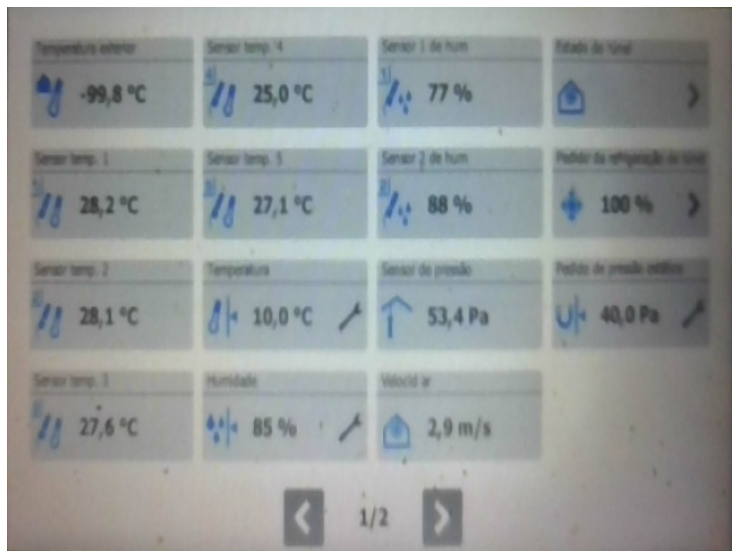

In [7]:
#Obtenção da matriz de transformação

pts1 = np.float32(pontos_maior)

pts2 = np.float32([[0,0], [W, 0], [W, H], [0, H]])

matriz = cv2.getPerspectiveTransform(pts1, pts2)

#Transformação de perspectiva

transform = cv2.warpPerspective(original, matriz, (W, H))

mostrar(transform)

In [8]:
#função para binarizar a imagem com o opencv

def preprocessamento(img):
  maior = cv2.resize(img, None, fx=3.4, fy=3.4, interpolation=cv2.INTER_CUBIC)
  valor, otsu = cv2.threshold(maior, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
  return otsu

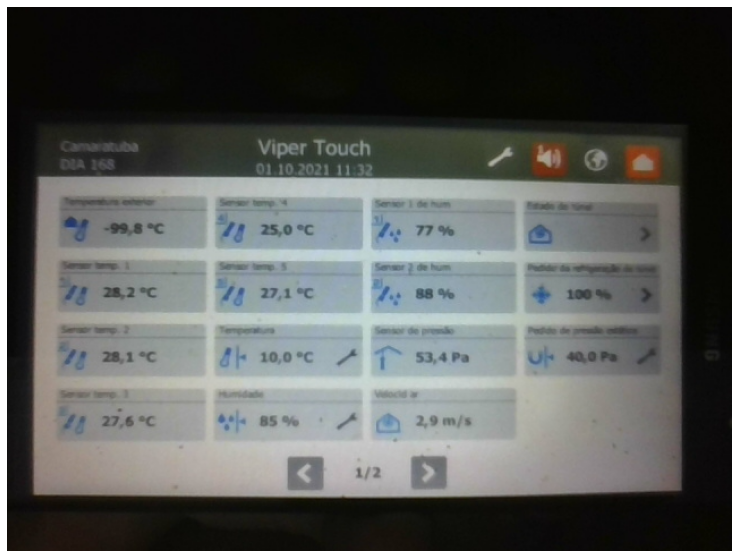

In [9]:
#Reconhecimento de caracteres

#salvando o caminho do excultavel do tesseract (necessario no windowns)

# Modificar diacordo com o caminho, possível erro ao rodar pela primeira vez em uma máquina
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'

#Dectecção Data,Hora,local

#carregando imagem
img_data_hora = original.copy()
mostrar(img_data_hora)

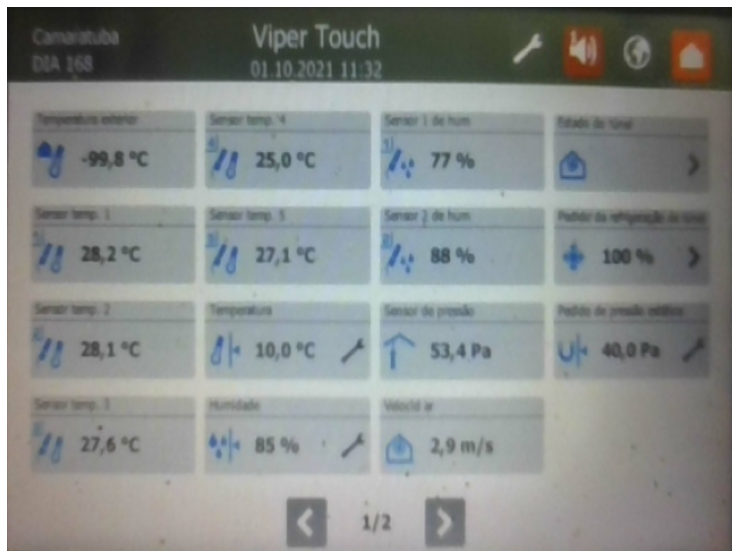

In [10]:
#modificando pontos
pontos_maior[0][0][1] -= pontos_maior[0][0][1] * (30/100)
pontos_maior[1][0][1] -= pontos_maior[1][0][1] * (30/100)

#formando matiz trsformação
pts1 = np.float32(pontos_maior)
matriz = cv2.getPerspectiveTransform(pts1, pts2)

#transformando a pespectiva
transform_data_hora = cv2.warpPerspective(img_data_hora, matriz, (W, H))

mostrar(transform_data_hora)

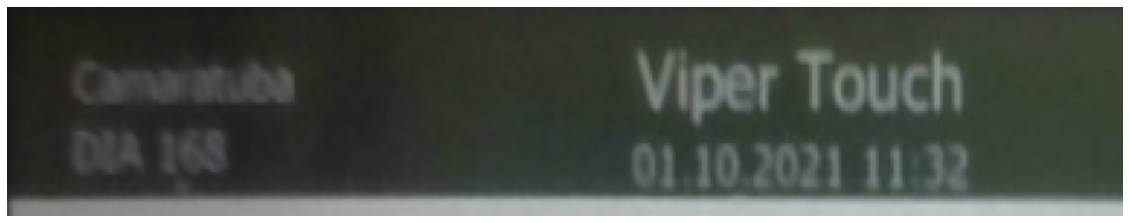

In [11]:
#calculando pata fechar no cabeçario
x_data = int (transform_data_hora.shape[1] - (transform_data_hora.shape[1] * (40/100)))
y_data = int (transform_data_hora.shape[0] - (transform_data_hora.shape[0] * (85/100)))

#fechando no cabeçario
transform_data_hora = transform_data_hora[:y_data,:x_data]
mostrar(transform_data_hora)

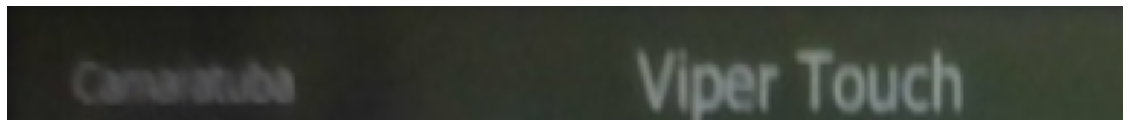

In [12]:
#Localizando as informações

#Local
x_local = int ((640/640) * transform_data_hora.shape[1])
y_local = int ((65/120) * transform_data_hora.shape[0])
local = transform_data_hora[:y_local,:x_local]
mostrar(local)

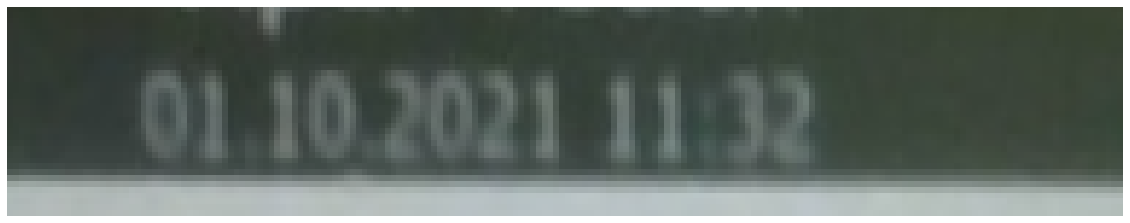

In [13]:
#data e hora
x1_data = int ((320/640) * transform_data_hora.shape[1])
x2_data = int ((640/640) * transform_data_hora.shape[1])
y1_data = int ((60/120) * transform_data_hora.shape[0])
y2_data = int ((120/120) * transform_data_hora.shape[0])
data_hora = transform_data_hora[y1_data:y2_data,x1_data:x2_data]
mostrar(data_hora)

In [14]:
#leituras de local,data e hora
custom_oem = r'-c tessedit_char_whitelist=abcdefghijklmnopqrstuvwxyz --psm 6'
leitura_local = pytesseract.image_to_string(local,config=custom_oem)
leitura_data_hora = pytesseract.image_to_string(data_hora)

#filtrando leituras

leitura_local = leitura_local.split(' ',1)
leitura_local = leitura_local[0]
#print(leitura_local)

#filtrando leituras

leitura_data_filtrada = ''
leitura_hora_filtrada = ''

#data e hora
leitura_data_hora = leitura_data_hora.split(' ',1)

#data
leitura_data = leitura_data_hora[0]
for i in leitura_data:
  if i == '.':
    leitura_data_filtrada = leitura_data_filtrada + '/'
  else:
    leitura_data_filtrada = leitura_data_filtrada + i

#hora
leitura_hora = leitura_data_hora[1]
for f in leitura_hora:
      if (f.isdigit() == True):
        leitura_hora_filtrada = leitura_hora_filtrada + f
      elif f == ':':
        leitura_hora_filtrada = leitura_hora_filtrada + f

#print(leitura_data_filtrada)
#print(leitura_hora_filtrada)

IndexError: list index out of range

In [15]:
#iniciando lista de caracteres lidos

line_data_csv = []

In [ ]:
#adicionando local

line_data_csv.append(leitura_local)

#Capturando a data e hora do sistema

tempo = datetime.datetime.now()

#adicionando a data do sistema operacional da máquina

data_string = tempo.strftime("%d/%m/%Y")
line_data_csv.append(data_string)

time_string = tempo.strftime("%H:%M")
line_data_csv.append(time_string)

#adicionando data e hora no array do csv

line_data_csv.append(leitura_data_filtrada)
line_data_csv.append(leitura_hora_filtrada)

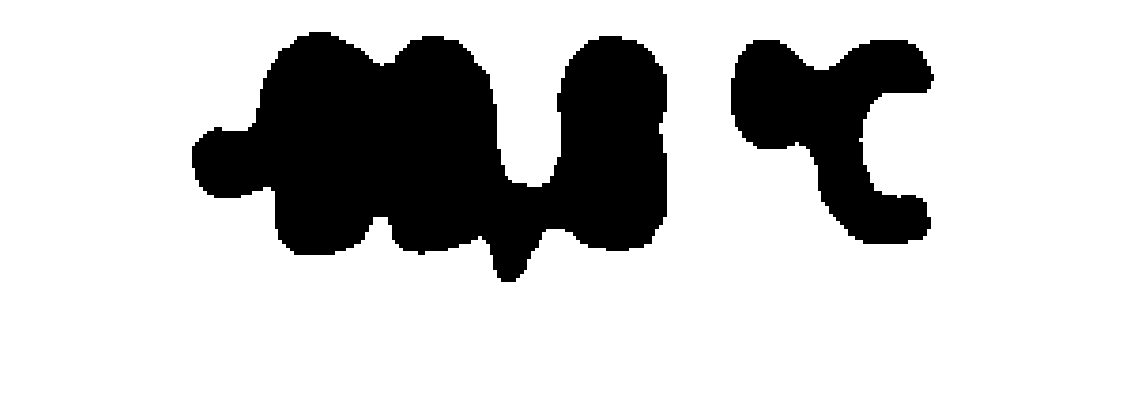

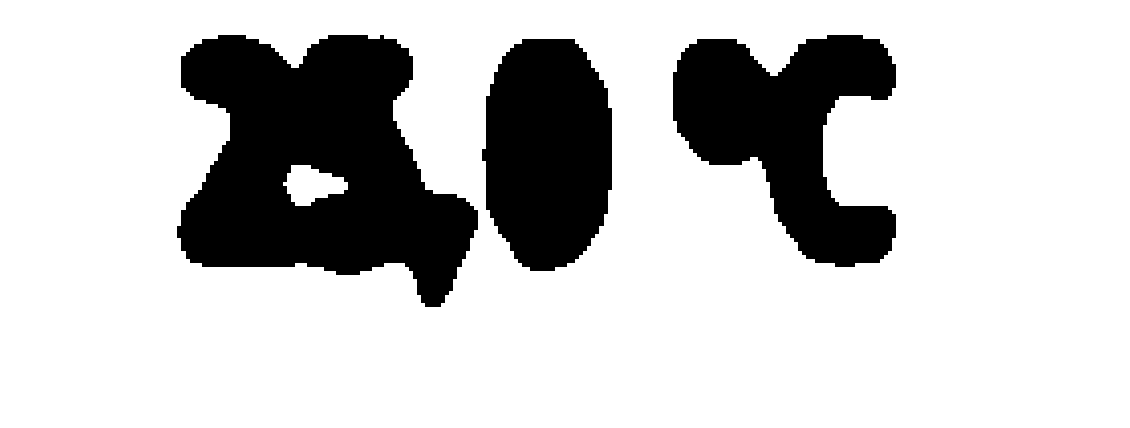

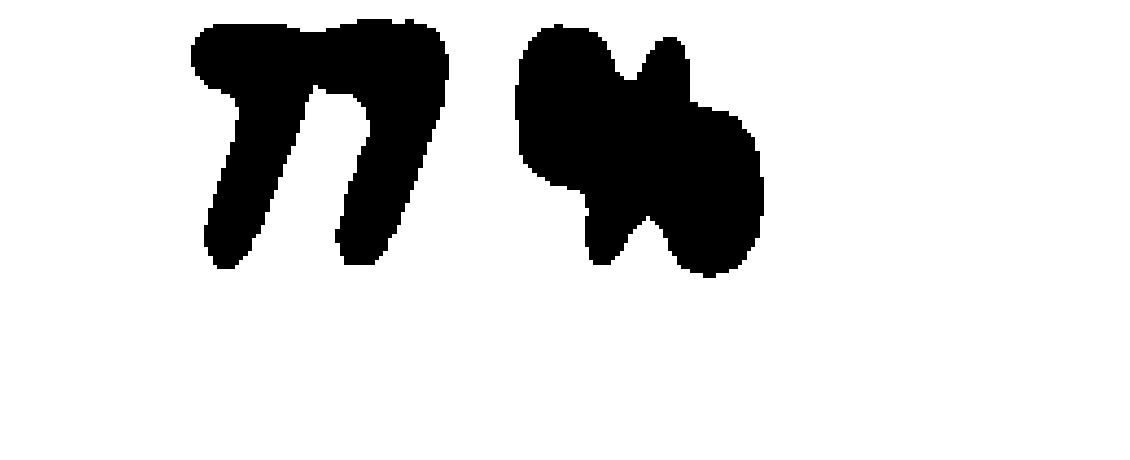

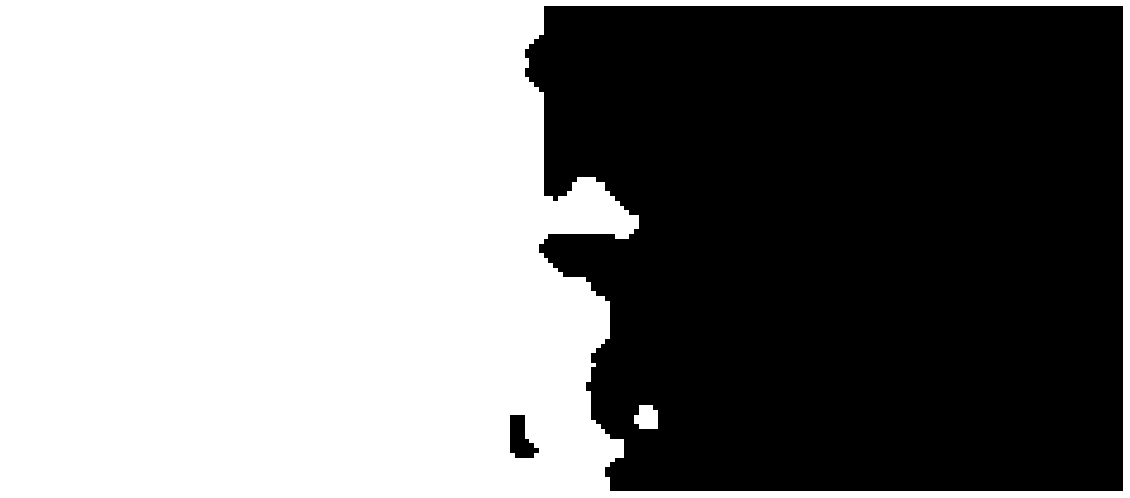

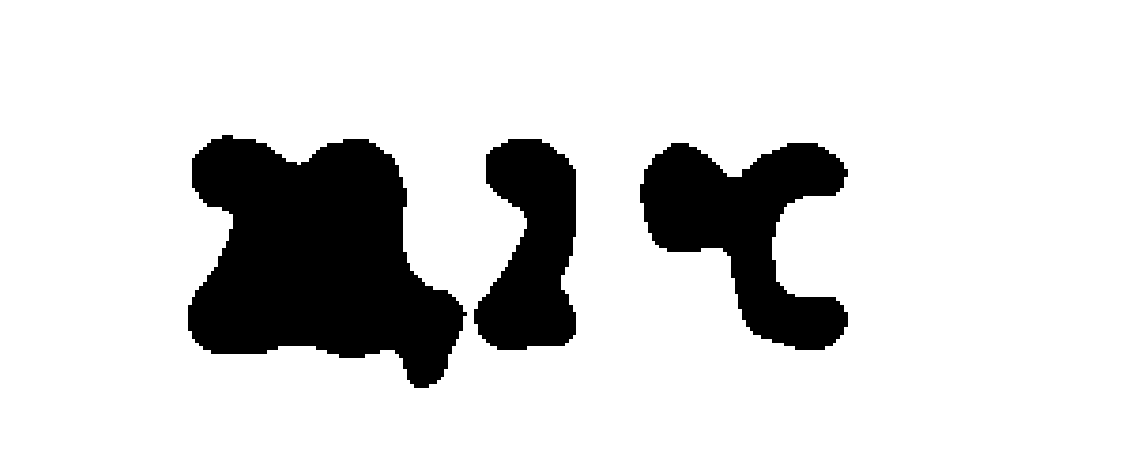

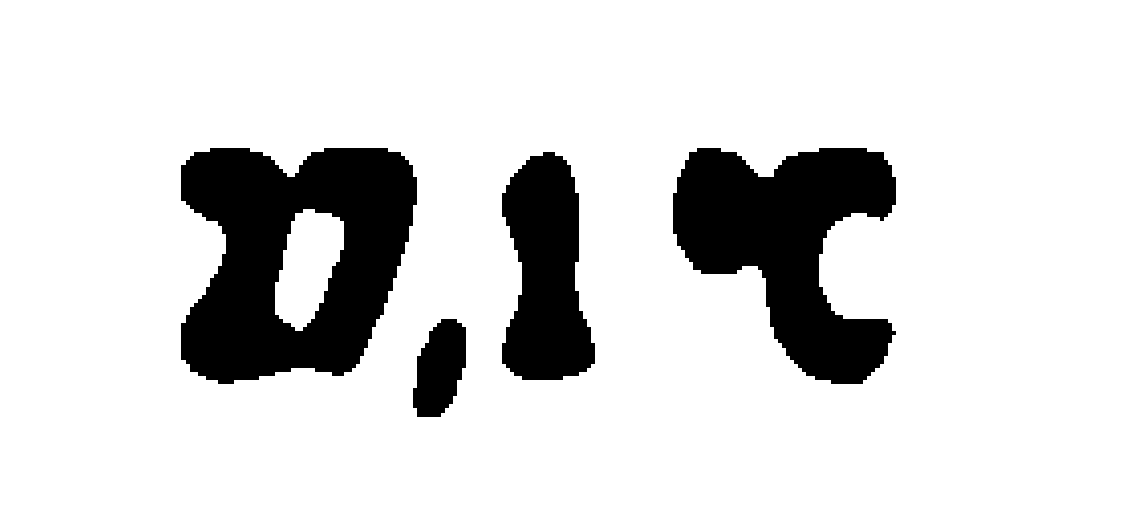

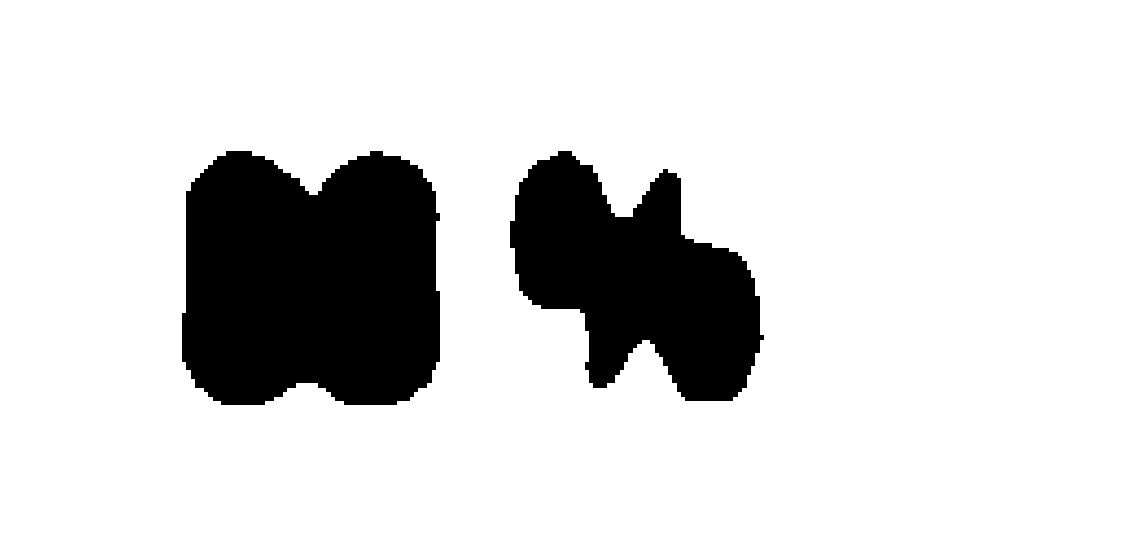

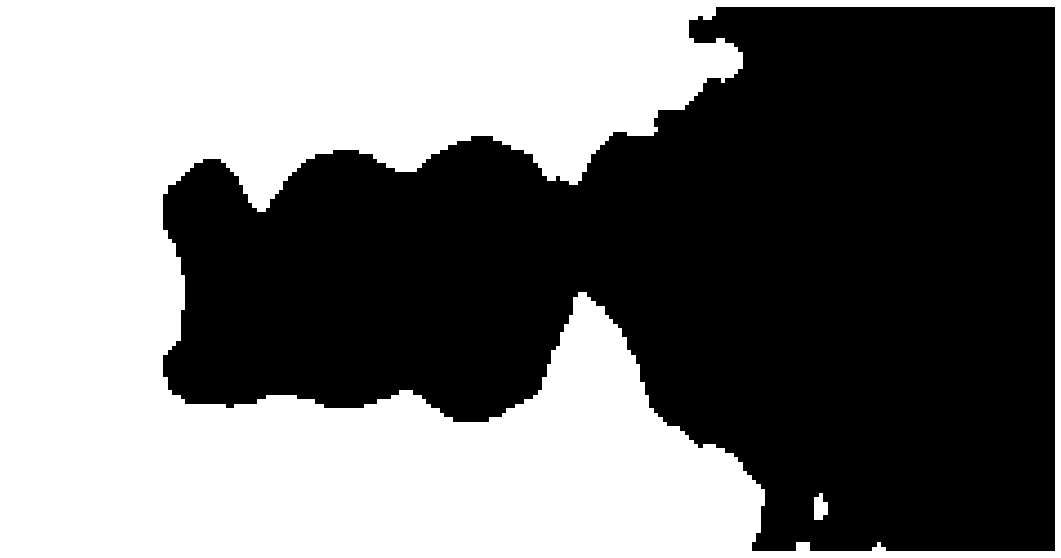

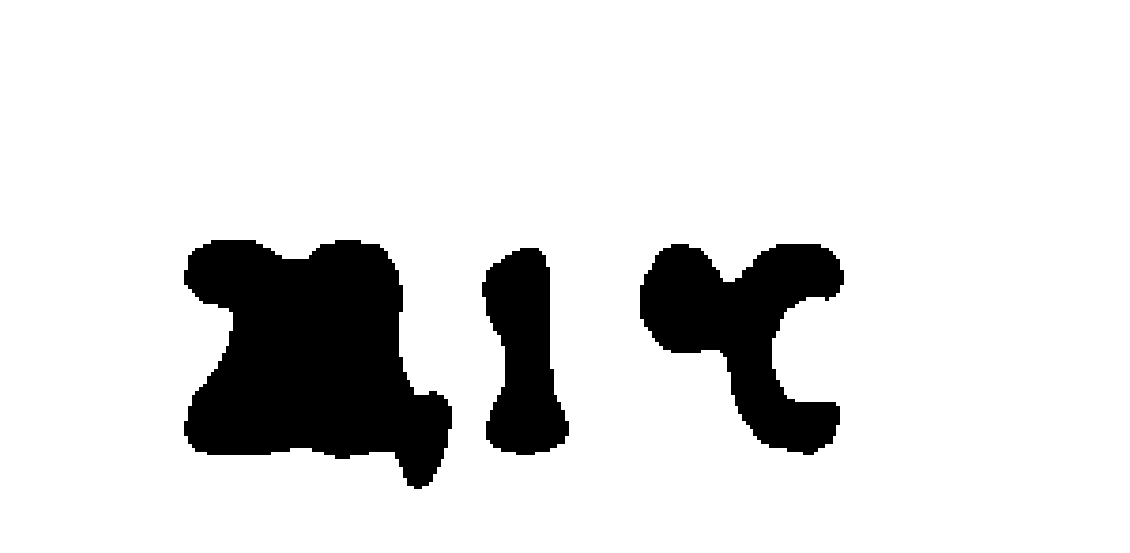

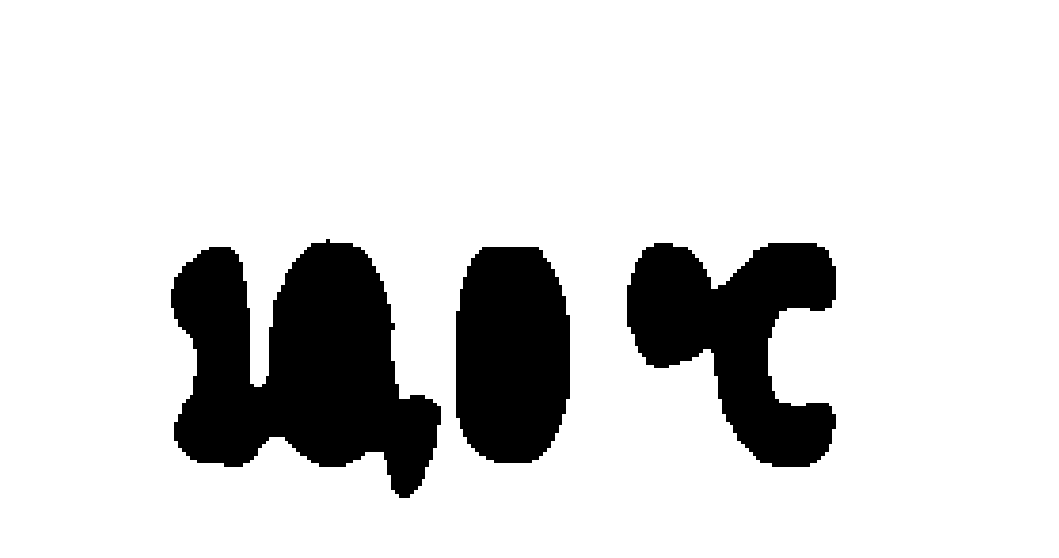

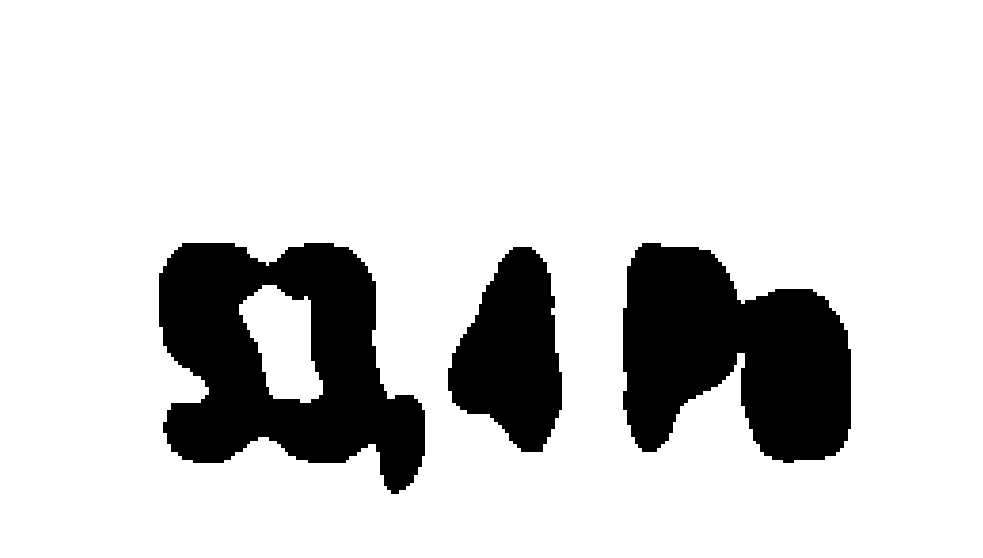

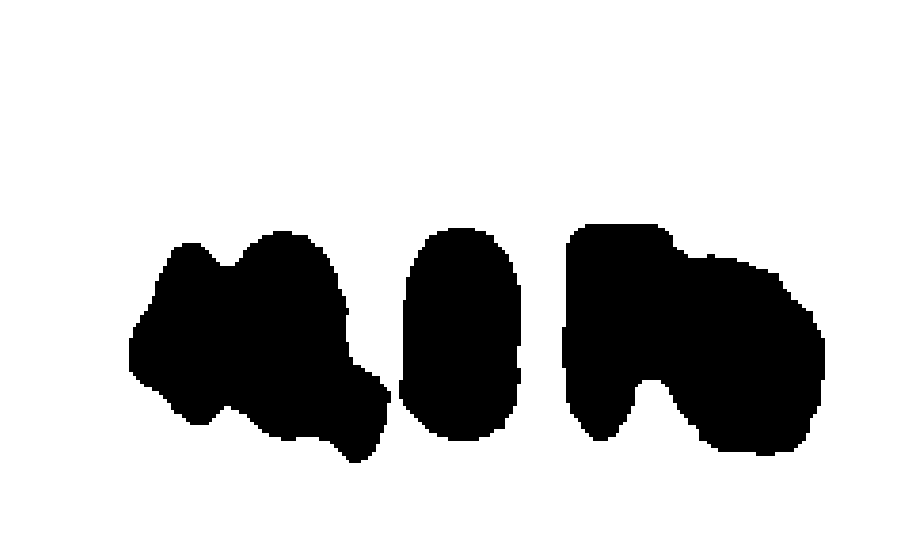

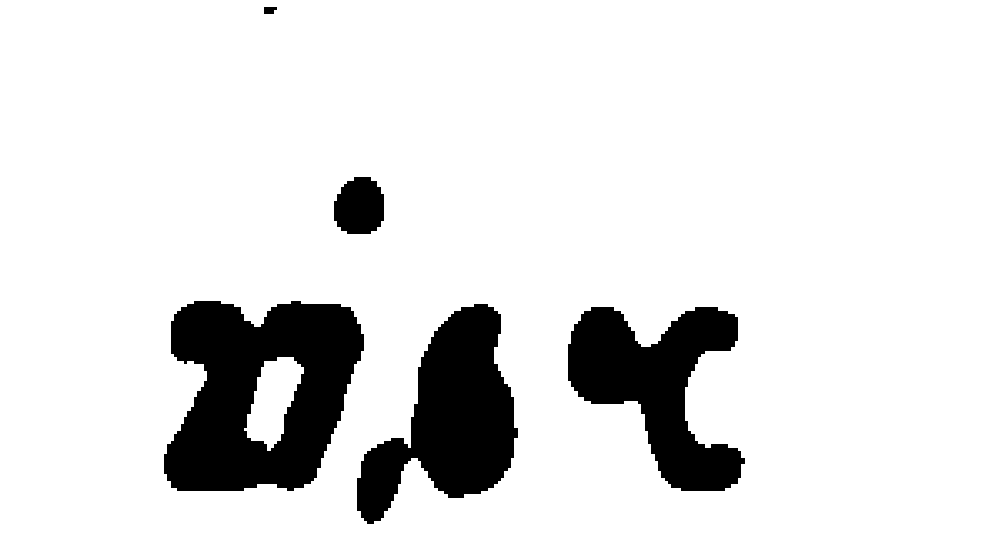

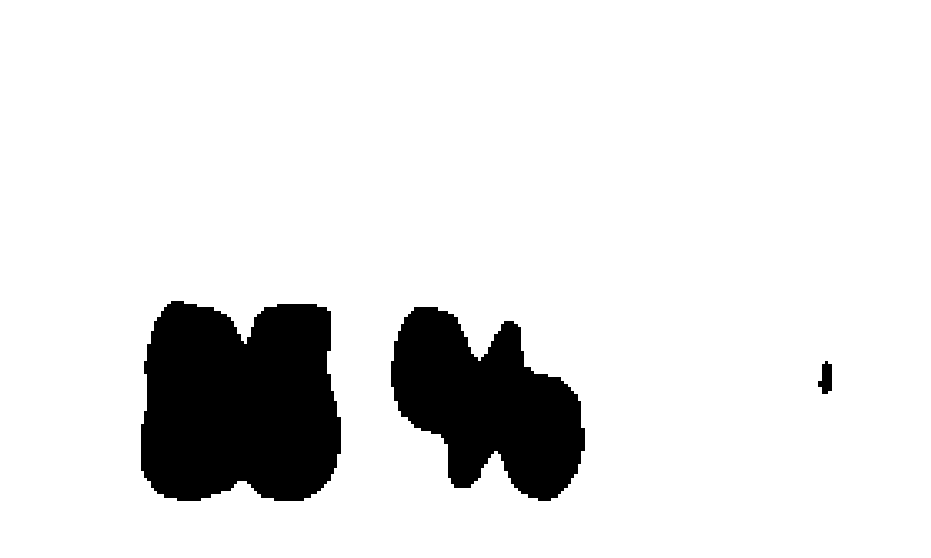

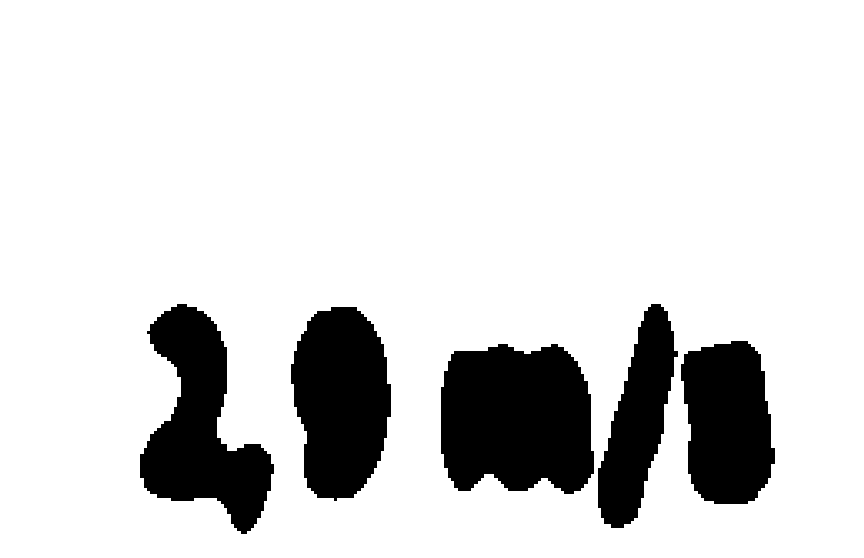

['0.8', '', '', '', '28.2', '', '6', '', '21', '100', '', '', '76', '', '29']


In [16]:
#Detecção de informações dos blocos

x1 = int((85/1067) * transform.shape[1])
x1_add = int((260/1067) * transform.shape[1])

x2 = int((230/1067) * transform.shape[1])
x2_add = int((250/1067) * transform.shape[1])

y1 = int((110/800) * transform.shape[0])
y1_add = int((150/800) * transform.shape[0])

y2 = int((160/800) * transform.shape[0])
y2_add = int((160/800) * transform.shape[0])

for i in range(4):
  x1 = int((85/1067) * transform.shape[1])
  x2 = int((230/1067) * transform.shape[1])
  if i > 0:
    y1 = y1 + y1_add
    y2 = y2 + y2_add

  for j in range(4):
    #if i == 0 and j == 3:
     # break
    if i == 3 and j == 3:
      break
    if j > 0:
      x1 = x1 + x1_add
      x2 = x2 + x2_add

    janela=transform[y1:y2, x1:x2]

    janelaBW=cv2.cvtColor(janela, cv2.COLOR_BGR2GRAY)
    janelaBW = np.around((janelaBW-48)*1.4)
    janelaBW = janelaBW.astype(np.uint8)

    janela_processada = preprocessamento(janelaBW)

    mostrar(janela_processada)

    leitura = pytesseract.image_to_string(janela_processada)

    #print(leitura)

    #filtro de caracteres
    leitura_filtrada = ''

    for f in leitura:
      if (f.isdigit() == True):
        leitura_filtrada = leitura_filtrada + f
      elif f == '-':
        leitura_filtrada = leitura_filtrada + f
      elif f == ',':
        leitura_filtrada = leitura_filtrada + '.'
      elif f == ' ':
        pass
      elif f == '\n':
        pass
      else:
        break
    line_data_csv.append(leitura_filtrada)

print(line_data_csv)